# Отток клиентов

**Нам известно:** Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель проекта:** Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Задачи проекта:** Построить модель с предельно большим значением *F1*-меры. Чтобы считать проект успешным, нам нужно довести метрику до 0.59. Будем проводить проверку *F1*-меры на тестовой выборке.


*Дополнительно измерим AUC-ROC, сравнивая её значение с F1-мерой.*

# Описание данных


**Признаки:**

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    
**Целевой признак:**

    Exited — факт ухода клиента
    
    
Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# План работы

1. Подготовка данных для дальнейшего исследования и анализа (EDA)
2. Исследование задачи: подбор оптимальной модели и ее гиперпараметров без учета дисбаланнса
3. Борьба с дисбалансом: создание функций для корректного анализа отобранной модели 
4. Проведение тестирование модели на отложенной выборке с целью проверки корретности разработанного алгоритма

## Подготовка данных

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score,  precision_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

import pandas as pd
import random 
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

# warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv("/datasets/Churn.csv")
except:
     print("Проверьте коректность имени пути к файлу или наличие самого файла в каталоге!")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
for x in df.columns:
    print("Кол-во явных дубликтов для столбца", x, "равняется", df[x].duplicated().sum())

Кол-во явных дубликтов для столбца RowNumber равняется 0
Кол-во явных дубликтов для столбца CustomerId равняется 0
Кол-во явных дубликтов для столбца Surname равняется 7068
Кол-во явных дубликтов для столбца CreditScore равняется 9540
Кол-во явных дубликтов для столбца Geography равняется 9997
Кол-во явных дубликтов для столбца Gender равняется 9998
Кол-во явных дубликтов для столбца Age равняется 9930
Кол-во явных дубликтов для столбца Tenure равняется 9988
Кол-во явных дубликтов для столбца Balance равняется 3618
Кол-во явных дубликтов для столбца NumOfProducts равняется 9996
Кол-во явных дубликтов для столбца HasCrCard равняется 9998
Кол-во явных дубликтов для столбца IsActiveMember равняется 9998
Кол-во явных дубликтов для столбца EstimatedSalary равняется 1
Кол-во явных дубликтов для столбца Exited равняется 9998


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


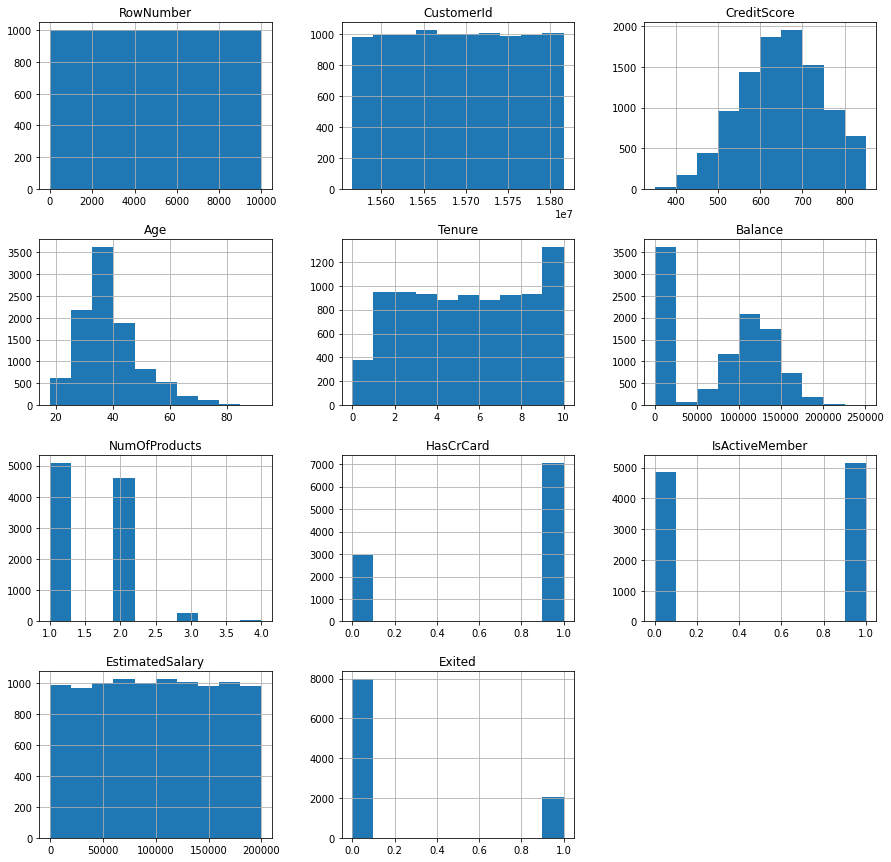

In [7]:
df.hist(figsize=(15, 15))
plt.show()

In [8]:
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


**Промежуточные выводы:**
 
   1. Видно, что у целевого признака есть явный дисбаланс классов: фактический уход клиентов практически в 4 раза меньше, чем отсутствие фактического ухода клиентов.
   2. Графики кредитного рейтинга и возраста близки к нормальному распределению;
   3. Признаки наличие кредитной карты и активность клиента представляют собой бинарную классификацию, где у первой тех кто имеет кредитную карту практически в 2.5 раза больше, чем тех кто не имеет, в то время как у второго обе категориальные переменные практически равны; 
   4. Количество продуктов банка, использумых клиентов представляет собой дискретную классификацию, у которой наблюдается практически равное соотноотношение у тех, кто использует 1-2 продукта, и явно видна малая часть тех, кто использует 3 и 4 соотвественно.
   5. У признака баланс видна значимая доля тех, у кого баланс на счете составляет 0, - что может сведетельствовать о том, что это либо новые клиенты, либо люди более не пополняют свой баланс

****

## Исследование задачи

**В данном разделе остановимся на том, что необходимо:**
  1. Отбросить неинформативные для нас признаки;
  2. Преобразовать категориальные признаки в количественные при помощи техники one-hot-encoding;
  3. Избавится от пропусков с помощью замены на медианное значение;
  4. Разделить выборки,  проверить корретность их деления в соотношении 3:1:1;
  5. Масштабировать определенные признаки за счет того, что их количественные оценки огромны;
  6. Провести подбор оптимальных гиперпараметров через цикл и через GreadSearchCV;

Отбросить неинформативные для нас признаки;

In [9]:
df = df.drop(["Surname", "CustomerId", "RowNumber"], axis=1)

Избавится от пропусков с помощью замены на медианное значение;

In [10]:
v = df['Tenure'].median()
df['Tenure'] =  df['Tenure'].fillna(v)

Преобразовать категориальные признаки в количественные при помощи техники one-hot-encoding;

In [13]:
df = pd.get_dummies(df, drop_first=True)

Зададим целевой признак и признаки, от которых строится прогноз по целевому

In [14]:
features = df.drop("Exited",axis=1)
target = df['Exited']

Разделить выборки, проверить корретность их деления в соотношении 3:1:1;

In [15]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                      train_size=0.6, 
                                                                                      random_state=42,
                                                                                      stratify=target)

In [16]:
features_test, features_validate, target_test, target_validate = train_test_split(features_test, target_test, 
                                                                                      train_size=0.5, 
                                                                                      random_state=42,
                                                                                      stratify=target_test)

In [17]:
print(df['Exited'].sum())
p = df['Exited'].sum()
print()
print(target_train.sum() / p)
print(target_test.sum() / p)
print(target_validate.sum() / p)

2037

0.5999018163966617
0.20029455081001474
0.19980363279332353


Масштабировать определенные признаки за счет того, что их количественные оценки огромны;

In [18]:
numeric = ['Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_validate[numeric] = scaler.transform(features_validate[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_174/1754425726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


**Проведем подбор оптимальных гиперпараметров через цикл и через GreadSearchCV:**

In [19]:
%%time 
max_depth = None
min_samples_split = None
best_result = 0
best_depth = 0
best_msp = 0
for depth in range(1, 10):
    for msp in tqdm(range(2, 11)): # tqdm будет показывать время выполнения когда проходимся по циклу
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion='gini', min_samples_split=msp) # инициализируем модель DecisionTreeClassifier с параметрами проходящими по циклу
        model = model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_validate) # получим предсказания модели на валидационной выборке
        # print("min_samples_split=", msp, "     max_depth =", depth, "    accuracy_score: ", end='')
        result = accuracy_score(target_validate, predictions_valid) # посчитаем значение метрики  accuracy_score на валидационной выборке
        # print(accuracy_score(target_validate, predictions_valid))
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_msp = msp
            
print()
print("Наилучшая модель на валидационной выборке:", best_result, "Глубина дерева:", best_depth, "Минимальное число разделений:", best_msp)
print("Использовался критерий 'gini'")
# %%time измерит в конце время ожидания и выполнения 

100%|██████████| 9/9 [00:00<00:00, 32.86it/s]


Наилучшая модель на валидационной выборке: 0.8545 Глубина дерева: 5 Минимальное число разделений: 2
Использовался критерий 'gini'
CPU times: user 1.48 s, sys: 35.7 ms, total: 1.52 s
Wall time: 1.61 s


In [20]:
%%time 
n_estimators = None
min_samples_leaf = None
best_result = 0
best_estimators = 0
best_msl = 0
for estimators in tqdm(range(100, 107)): # tqdm будет показывать время выполнения когда проходимся по циклу
    for msl in range(1, 7):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimators, criterion="gini", min_samples_leaf=msl) # инициализируем модель RandomForestClassifier с параметрами проходящими по циклу
        model = model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_validate)  # получим предсказания модели на валидационной выборке
        # print("min_samples_leaf=", msl,"    n_estimators =", estimators, "    accuracy_score: ", end='')
        result = accuracy_score(target_validate, predictions_valid)  # посчитаем значение метрики  accuracy_score на валидационной выборке
        # print(accuracy_score(target_validate, predictions_valid))
        if result > best_result:
            best_model = model
            best_result = result
            best_estimators = estimators
            best_msl = msl
        
print()
print("Наилучшая модель на валидационной выборке:", best_result, "Оценки:", best_estimators, "Минимальное число листов:", best_msl)
print("Использовался критерий 'gini'")
# %%time измерит в конце время ожидания и выполнения 

100%|██████████| 7/7 [00:34<00:00,  4.94s/it]


Наилучшая модель на валидационной выборке: 0.863 Оценки: 103 Минимальное число листов: 3
Использовался критерий 'gini'
CPU times: user 34.1 s, sys: 293 ms, total: 34.4 s
Wall time: 34.6 s


In [21]:
%%time  

model_gs = RandomForestClassifier(random_state=12345, criterion="gini")

parametrs_gs  = {
    'n_estimators': [100, 102, 103, 104, 105, 106, 107],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
}


gs = GridSearchCV(estimator = model_gs,
                  param_grid = parametrs_gs,
                  cv=5)

# gs.fit(pd.concat([features_train, features_validate]), pd.concat([target_train, target_validate]))
gs.fit(features_train, target_train)
print(gs.best_estimator_)
print(gs.best_score_)

# CPU times: user 2min 35s, sys: 571 ms, total: 2min 36s
# Wall time: 2min 36s

RandomForestClassifier(min_samples_leaf=4, n_estimators=102, random_state=12345)
0.8623333333333335
CPU times: user 2min 25s, sys: 1.06 s, total: 2min 26s
Wall time: 2min 26s


In [22]:
%%time  

model_gs = DecisionTreeClassifier(random_state=12345, criterion="gini")

parametrs_gs  = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}


gs = GridSearchCV(estimator = model_gs,
                  param_grid = parametrs_gs,
                  cv=5)

# gs.fit(pd.concat([features_train, features_validate]), pd.concat([target_train, target_validate]))
gs.fit(features_train, target_train)
print(gs.best_estimator_)
print(gs.best_score_)

# CPU times: user 8.22 s, sys: 40 ms, total: 8.26 s
# Wall time: 8.26 s

DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=12345)
0.8548333333333333
CPU times: user 7.77 s, sys: 59.9 ms, total: 7.83 s
Wall time: 7.85 s


**По отобранным гиперпараметрам  инициализируем модель и получим оценки без учета дисбаланса**

F1:  0.6073298429319371
ROC_AUC:  0.7457781356086441
RECALL:  0.5700245700245701
PRECISION:  0.6498599439775911
Accuracy_score  0.85


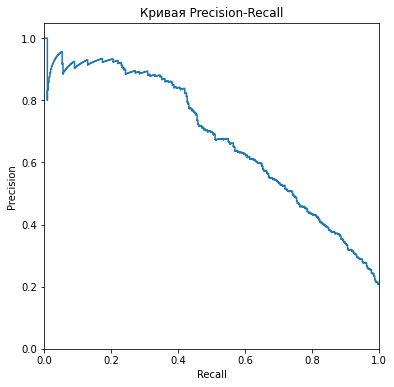

CPU times: user 1.05 s, sys: 19.9 ms, total: 1.07 s
Wall time: 1.08 s


In [23]:
%%time
model = RandomForestClassifier(random_state=12345, criterion='gini', min_samples_leaf=3, n_estimators=106, class_weight='balanced')
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_validate)
print("F1: ", f1_score(target_validate, predicted_valid))
print("ROC_AUC: ", roc_auc_score(target_validate, predicted_valid))
print("RECALL: ", recall_score(target_validate, predicted_valid))
print("PRECISION: ", precision_score(target_validate, predicted_valid))
print("Accuracy_score ", accuracy_score(target_validate, predicted_valid))
probabilities_valid = model.predict_proba(features_validate)
precision, recall, thresholds = precision_recall_curve(target_validate, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

F1:  0.5584299732381801
ROC_AUC:  0.7586577332340045
RECALL:  0.769041769041769
PRECISION:  0.438375350140056
Accuracy_score  0.7525


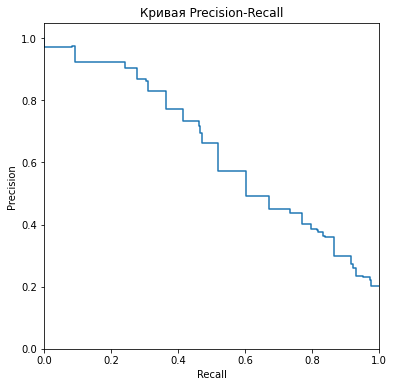

CPU times: user 138 ms, sys: 16 ms, total: 154 ms
Wall time: 163 ms


In [24]:
%%time
model = DecisionTreeClassifier(random_state=12345, max_depth=6, criterion='gini', min_samples_split=11, class_weight='balanced')
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_validate)
print("F1: ", f1_score(target_validate, predicted_valid))
print("ROC_AUC: ", roc_auc_score(target_validate, predicted_valid))
print("RECALL: ", recall_score(target_validate, predicted_valid))
print("PRECISION: ", precision_score(target_validate, predicted_valid))
print("Accuracy_score ", accuracy_score(target_validate, predicted_valid))
probabilities_valid = model.predict_proba(features_validate)
precision, recall, thresholds = precision_recall_curve(target_validate, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

**Выводы по разделу:**

1. Была выполнена предобработка данных, разделены выборки и отобранны гиперпараметры 
2. Из полученных оценок понимаем, что Случайный лес для нас оптимальная модель

****

## Борьба с дисбалансом

**Отобразим графически, как соотносится баланс классов для целевого признака**

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

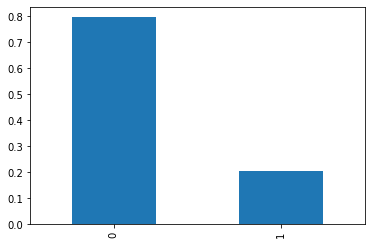

In [25]:
class_frequency = df['Exited'].value_counts(normalize=2/len(df['Exited']))
print(class_frequency)
class_frequency.plot(kind='bar')

**Создадим функции, которые будут отвечать за методы борьбы с дисбалансом, внутри их перемешаем признаки и вернем их. После вызовим функцию при объявление новых переменных**

In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [27]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

**Сравним и выберем наилучший способ борьбы с дисбалансом, подобрав перед этим новые оптимальные гиперпараметры в GridSearchCV:**

In [28]:
%%time  

model_gs = RandomForestClassifier(random_state=12345, criterion="gini", class_weight='balanced')

parametrs_gs  = {
    'n_estimators': [100, 102, 103, 104, 105, 106, 107],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
}


gs = GridSearchCV(estimator = model_gs,
                  param_grid = parametrs_gs,
                  cv=5)

gs.fit(features_upsampled, target_upsampled)
print(gs.best_estimator_)
print(gs.best_score_)

# RandomForestClassifier(class_weight='balanced', n_estimators=106,
                       # random_state=12345)
# 0.9561355566600026
# CPU times: user 3min 18s, sys: 468 ms, total: 3min 19s
# Wall time: 3min 19s

RandomForestClassifier(class_weight='balanced', n_estimators=106,
                       random_state=12345)
0.9561355566600026
CPU times: user 3min 42s, sys: 1.52 s, total: 3min 44s
Wall time: 3min 44s


In [29]:
%%time  

model_gs = RandomForestClassifier(random_state=12345, criterion="gini", class_weight='balanced')

parametrs_gs  = {
    'n_estimators': [100, 102, 103, 104, 105, 106, 107],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
}


gs = GridSearchCV(estimator = model_gs,
                  param_grid = parametrs_gs,
                  cv=5)

gs.fit(features_downsampled, target_downsampled)
print(gs.best_estimator_)
print(gs.best_score_)


# RandomForestClassifier(min_samples_leaf=4, n_estimators=105, random_state=12345)
# 0.876162193318798
# CPU times: user 45.3 s, sys: 240 ms, total: 45.5 s
# Wall time: 45.5 s

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=107, random_state=12345)
0.7682151840254606
CPU times: user 1min 19s, sys: 531 ms, total: 1min 20s
Wall time: 1min 20s


In [30]:
%%time
model = RandomForestClassifier(random_state=12345, criterion='gini', min_samples_leaf=4, n_estimators=105, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_validate)
print("F1: ", f1_score(target_validate, predicted_valid))
print("ROC_AUC: ", roc_auc_score(target_validate, predicted_valid))
print("RECALL: ", recall_score(target_validate, predicted_valid))
print("PRECISION: ", precision_score(target_validate, predicted_valid))
print("Accuracy_score ", accuracy_score(target_validate, predicted_valid))


F1:  0.5961538461538461
ROC_AUC:  0.7794543387763726
RECALL:  0.7616707616707616
PRECISION:  0.48973143759873616
Accuracy_score  0.79
CPU times: user 563 ms, sys: 4.03 ms, total: 568 ms
Wall time: 573 ms


In [31]:
%%time
model = RandomForestClassifier(random_state=12345, criterion='gini', min_samples_leaf=3, n_estimators=106)
model = model.fit(features_upsampled, target_upsampled)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_validate)
print("F1: ", f1_score(target_validate, predicted_valid))
print("ROC_AUC: ", roc_auc_score(target_validate, predicted_valid))
print("RECALL: ", recall_score(target_validate, predicted_valid))
print("PRECISION: ", precision_score(target_validate, predicted_valid))
print("Accuracy_score ", accuracy_score(target_validate, predicted_valid))


F1:  0.6070133010882709
ROC_AUC:  0.7553092383600859
RECALL:  0.6167076167076168
PRECISION:  0.5976190476190476
Accuracy_score  0.8375
CPU times: user 1.28 s, sys: 11.5 ms, total: 1.29 s
Wall time: 1.38 s


**Посмотрим, как изменяется точность и полнота, при увелечении порога**

In [32]:
model = RandomForestClassifier(random_state=12345, criterion='gini', min_samples_leaf=3, n_estimators=106, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_validate)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_validate, predicted_valid)
    recall = recall_score(target_validate, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000
Порог = 0.02 | Точность = 0.211, Полнота = 0.998
Порог = 0.04 | Точность = 0.222, Полнота = 0.990
Порог = 0.06 | Точность = 0.233, Полнота = 0.978
Порог = 0.08 | Точность = 0.249, Полнота = 0.971
Порог = 0.10 | Точность = 0.265, Полнота = 0.966
Порог = 0.12 | Точность = 0.278, Полнота = 0.956
Порог = 0.14 | Точность = 0.296, Полнота = 0.948
Порог = 0.16 | Точность = 0.313, Полнота = 0.934
Порог = 0.18 | Точность = 0.327, Полнота = 0.912
Порог = 0.20 | Точность = 0.343, Полнота = 0.892
Порог = 0.22 | Точность = 0.354, Полнота = 0.865
Порог = 0.24 | Точность = 0.370, Полнота = 0.845
Порог = 0.26 | Точность = 0.387, Полнота = 0.826
Порог = 0.28 | Точность = 0.405, Полнота = 0.808


**Выводы по разделу:**

   1. В ходе борьбы с дисбалансом было применено несколько способов, из которых наиболее оптимальным для нас вышел upnsampled

   2. При увелечении порога уменьшается полнота, но увеличивается точность

****

## Тестирование модели

**Из моделей выбирем Случайный лес классификатор для тестовой выборке как полученную наилучшую модель на валидационной выборке со следующими гиперпараметрами:**

       1. random_state=12345
       2. criterion='gini'
       3. min_samples_leaf=3
       4. class_weight='balanced'
       5. n_estimators=106

F1:  0.6317044100119189
ROC_AUC:  0.7726192235688244
RECALL:  0.6495098039215687
PRECISION:  0.6148491879350348
AССURACY_SCORE:  0.8455


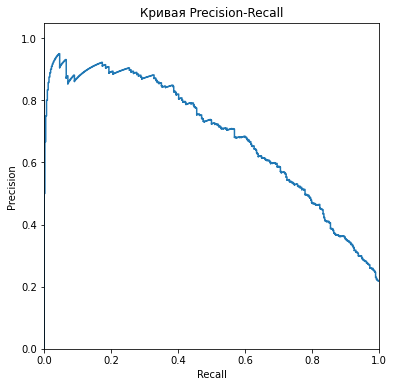

CPU times: user 1.31 s, sys: 39.6 ms, total: 1.35 s
Wall time: 1.4 s


In [33]:
%%time
model = RandomForestClassifier(random_state=12345, criterion='gini', min_samples_leaf=3, n_estimators=106, class_weight='balanced')
model = model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("F1: ", f1_score(target_test, predicted_test))
print("ROC_AUC: ", roc_auc_score(target_test, predicted_test))
print("RECALL: ", recall_score(target_test, predicted_test))
print("PRECISION: ", precision_score(target_test, predicted_test))
print("AССURACY_SCORE: ", accuracy_score(target_test, predicted_test))

# ROC
probabilities = model.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

**Заключение:**

1. Наша модель (алгоритм) вполне пригодна, поскольку она дала результат f1_score не ниже допустимого нами порога: 0.59

****

## Выводы по полученным результатам

**1) В начале исследования проверили информацию об нашем датасете и сделали промежуточные выводы:**
   1. Видно, что у целевого признака есть явный дисбаланс классов: фактический уход клиентов практически в 4 раза меньше, чем отсутствие фактического ухода клиентов.
   2. Графики кредитного рейтинга и возраста близки к нормальному распределению;
   3. Признаки наличие кредитной карты и активность клиента представляют собой бинарную классификацию, где у первой тех кто имеет кредитную карту практически в 2.5 раза больше, чем тех кто не имеет, в то время как у второго обе категориальные переменные практически равны; 
   4. Количество продуктов банка, использумых клиентов представляет собой дискретную классификацию, у которой наблюдается практически равное соотноотношение у тех, кто использует 1-2 продукта, и явно видна малая часть тех, кто использует 3 и 4 соотвественно.
   5. У признака баланс видна значимая доля тех, у кого баланс на счете составляет 0, - что может предположительно  сведетельствовать о том, что это либо новые клиенты, либо люди более не пополняют свой баланс

**2) В данном разделе остановились на том, что было необходимо:**

  1. Отбросить неинформативные для нас признаки;
  2. Преобразовать категориальные признаки в количественные при помощи техники one-hot-encoding;
  3. Избавится от пропусков с помощью замены на медианное значение;
  4. Разделить выборки,  проверить корретность их деления в соотношении 3:1:1;
  5. Масштабировать определенные признаки за счет того, что их количественные оценки огромны;
  6. Провести подбор оптимальных гиперпараметров через цикл и через GreadSearchCV;


    
    
**2) После понимаем, что для Категориальных данных применимы лишь определенные методы предсказания, и в нашем случае у нас бинарная классификация для целевого признака (таргета) - 0 или 1**

    1. Рассмотрим две различные модели: `Решающее дерево` и `Случайный лес`
    2. Использовали GreadSearchCV - для перебора оптимальных гиперпараметров
    3. В ходе исследования удалось достичь f1_score не меньше 0.59 и была выбрана модель Случайного леса
    
**3) Борьба с дисбалансом:**

     1. Отобразили графически, как соотносится баланс классов для целевого признака
     2. Создадили функции, которые будут отвечать за методы борьбы с дисбалансом (upsampled, downsampled), внутри их перемешаем признаки и вернем их. После вызвали функции при объявление новых переменных
     3. Выбрали наилуший способ для борьбы с дисбалансом - upsampled
    
**4) Выбираем Случайный лес классификатор - как наилучшую модель (алгоритм) предсказания со следующими гиперпараметрами (f1_score = F1:  0.6002372479240806):**

     1. random_state=12345
     2. criterion='gini'
     3. min_samples_leaf=3
     4. class_weight='balanced'

    
**4) На тестовой выборке выполнили финальную проверку, с определеной лучшей моделью и ее конкретными гиперпараметра. И получили  F1, который равен соотвественно: 0.6254375729288215**

**4) Пришли к выводу о том, что наша модель - адекватна**